In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt5
# Add modules to the path
import sys
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos\\Python_git')
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos')
sys.path.insert(0, 'C:\\Users\\francescag\\Documents\\SourceTree_repos\\Python_git\\freely_moving_photometry_analysis')
import copy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import os
import matplotlib
import pandas as pd
import pickle
import peakutils
import functools
from scipy.signal import decimate
from utils.plotting import HeatMapParams
from utils.plotting import heat_map_and_mean, plot_one_side, calculate_error_bars
from utils.plotting import get_photometry_around_event
from scipy import stats
from utils.individual_trial_analysis_utils import ZScoredTraces, SessionData, CueAlignedData
from utils.post_processing_utils import *
import seaborn as sns

In [16]:
mouse_id = 'SNL_photo43'
date = '20210603'
all_experiments = get_all_experimental_records()
experiment_to_process = all_experiments[(all_experiments['date'] == date) & (all_experiments['mouse_id'] == mouse_id)]
session_data, trial_data = open_experiment(experiment_to_process)

In [25]:
saving_folder = 'W:\\photometry_2AC\\processed_data\\' + mouse_id + '\\'
demod_signal = np.load(saving_folder + mouse_id + '_' + date + "_smoothed_signal.npy" )

In [27]:
plt.plot(demod_signal)

In [17]:
params = {'state_type_of_interest': 5,
    'outcome': 1,
    'last_outcome': 0,  # NOT USED CURRENTLY
    'no_repeats' : 1,
    'last_response': 0,
    'align_to' : 'Time start',
    'instance': -1,
    'plot_range': [-6, 6],
    'first_choice_correct': 1,
     'cue': 'None'}
test = CustomAlignedData(session_data, params)

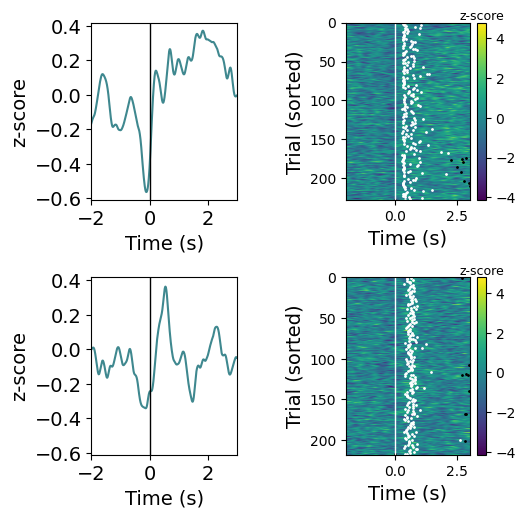

In [18]:
heat_map_and_mean(test, sort=False, error_bar_method=None, mean_across_mice=False, xlims=[-2,3])

In [19]:
trials_pre_state_change = np.where(test.contra_data.trial_nums <=149)[0]
trials_post_state_change = np.where(test.contra_data.trial_nums >149)[0]

In [20]:
trials_post_state_change.shape

(156,)

In [21]:
peaks = test.contra_data.trial_peaks
pre_peaks = [peaks[trial] for trial in trials_pre_state_change if peaks[trial].size > 0]
post_peaks = [peaks[trial] for trial in trials_post_state_change  if peaks[trial].size > 0]

In [22]:
font = {'size'   : 14}
matplotlib.rc('font', **font)

fig, axs1 = plt.subplots(1,1)
colours = cm.viridis(np.linspace(0.2, 0.7, 2))
pre_mean_trace = decimate(np.mean(test.contra_data.sorted_traces[trials_pre_state_change,:], axis=0), 10)
post_mean_trace = decimate(np.mean(test.contra_data.sorted_traces[ trials_post_state_change,:], axis=0), 10)
time_points = decimate(test.contra_data.time_points, 10)
traces = decimate(test.contra_data.sorted_traces, 10)
axs1.plot(time_points, pre_mean_trace, label='pre', color=colours[0])
pre_error_bar_lower, pre_error_bar_upper = calculate_error_bars(pre_mean_trace,
                                                        traces[trials_pre_state_change,:],
                                                        error_bar_method='ci')
                  
axs1.fill_between(time_points, pre_error_bar_lower, pre_error_bar_upper, alpha=0.4, linewidth=0, color=colours[0])
axs1.plot(time_points,post_mean_trace, label='post', color=colours[1])
post_error_bar_lower, post_error_bar_upper = calculate_error_bars(post_mean_trace,
                                                        traces[ trials_post_state_change,:],
                                                        error_bar_method='ci')
axs1.fill_between(time_points, post_error_bar_lower, post_error_bar_upper, alpha=0.4, linewidth=0, color=colours[1])
axs1.set_xlim([-2,2])
axs1.axvline([0], color='k')
axs1.set_ylabel('z-scored fluorescence')
axs1.set_xlabel('Time (s)')

axs1.spines['right'].set_visible(False)
axs1.spines['top'].set_visible(False)
plt.legend()
plt.tight_layout()
        


Bootstrapping...: 100%|████████████████| 1000/1000 [00:11<00:00, 89.17it/s]


In [2]:
# group data
processed_data_dir = os.path.join('W:\\photometry_2AC\\processed_data\\state_change_data')
state_change_data_file = os.path.join(processed_data_dir,  'state_change_data_nacc_mice.csv')
all_session_change_data = pd.read_pickle(state_change_data_file)

In [3]:
df1 = all_session_change_data[['mouse','trial number','trial type', 'peak size']]
df1 = df1.pivot_table(index=['mouse', 'trial type'], values=['peak size'], aggfunc=np.nanmean)
df1 = df1.reset_index()

In [4]:
decimate10 = functools.partial(decimate, 10)

In [5]:
all_session_change_data

,trial number,peak size,traces,trial type,mouse
0,0.0,-0.135372,"[-0.7679605066576128, -0.7679869450625265, -0....",pre,SNL_photo21
1,4.0,1.693213,"[0.9935759493821839, 0.9937665371848675, 0.993...",pre,SNL_photo21
2,5.0,-0.255186,"[-0.39565594635078044, -0.3955940902512134, -0...",pre,SNL_photo21
3,10.0,-0.110042,"[0.9019578653088225, 0.9020375219989957, 0.902...",pre,SNL_photo21
4,16.0,1.977163,"[-0.6097100340929787, -0.6095618843482161, -0....",pre,SNL_photo21
...,...,...,...,...,...
1556,459.0,3.277215,"[0.6344744065662126, 0.6343369547072031, 0.634...",post,SNL_photo44
1557,460.0,0.390971,"[1.1864075489193653, 1.187315725759052, 1.1882...",post,SNL_photo44
1558,463.0,2.921140,"[0.7310537351410799, 0.7307694861716405, 0.730...",post,SNL_photo44
1559,464.0,0.750983,"[-1.6508218673483641, -1.6506459523258679, -1....",post,SNL_photo44


In [6]:
all_session_change_data.head()

,trial number,peak size,traces,trial type,mouse
0,0.0,-0.135372,"[-0.7679605066576128, -0.7679869450625265, -0....",pre,SNL_photo21
1,4.0,1.693213,"[0.9935759493821839, 0.9937665371848675, 0.993...",pre,SNL_photo21
2,5.0,-0.255186,"[-0.39565594635078044, -0.3955940902512134, -0...",pre,SNL_photo21
3,10.0,-0.110042,"[0.9019578653088225, 0.9020375219989957, 0.902...",pre,SNL_photo21
4,16.0,1.977163,"[-0.6097100340929787, -0.6095618843482161, -0....",pre,SNL_photo21


In [7]:
# find mean traces and downsample
avg_traces = all_session_change_data.groupby(['mouse', 'trial type'])['traces'].apply(np.mean)
decimated = [decimate(trace[int(len(trace)/2):], 10) for trace in avg_traces]
avg_traces = avg_traces.reset_index()
avg_traces['decimated'] = pd.Series([_ for _ in decimated])

avg_traces.head()

,mouse,trial type,traces,decimated
0,SNL_photo21,post,"[0.11757407718784627, 0.11764368549064554, 0.1...","[0.2849924846949067, 0.2875324731799635, 0.290..."
1,SNL_photo21,pre,"[0.2302990564075248, 0.23031311975682833, 0.23...","[0.028910004914557023, 0.028417089350470593, 0..."
2,SNL_photo22,post,"[0.0020142276821464053, 0.0020098347752410977,...","[0.006149936242498089, 0.011509042529488542, 0..."
3,SNL_photo22,pre,"[0.03641823040163544, 0.036353350067144234, 0....","[-0.09078252413180969, -0.08504013812070647, -..."
4,SNL_photo26,post,"[0.05072342395670647, 0.0506983430399286, 0.05...","[0.38036357585871466, 0.38522979798134416, 0.3..."


In [8]:
# find peak size in pre condition and look for same time point in action
# alternatively, just find first peak for both. let's try that first. 

#plt.plot(avg_traces['decimated'].iloc[0])

first_peak_ids = [peakutils.indexes(i)[0] for i in avg_traces['decimated']]
avg_traces['peakidx'] = first_peak_ids
peaks = [trace[idx] for idx, trace in zip(first_peak_ids, avg_traces['decimated'])]
avg_traces['peak'] = peaks
avg_traces.set_index(['mouse', 'trial type'])

prepeak = avg_traces[avg_traces['trial type']=='pre']['peak']
postpeak = avg_traces[avg_traces['trial type']=='post']['peak']
result = stats.ttest_rel(prepeak, postpeak)
result

Ttest_relResult(statistic=-0.823277266833952, pvalue=0.4478229936702294)

In [9]:
avg_traces

,mouse,trial type,traces,decimated,peakidx,peak
0,SNL_photo21,post,"[0.11757407718784627, 0.11764368549064554, 0.1...","[0.2849924846949067, 0.2875324731799635, 0.290...",185,0.574251
1,SNL_photo21,pre,"[0.2302990564075248, 0.23031311975682833, 0.23...","[0.028910004914557023, 0.028417089350470593, 0...",414,0.266602
2,SNL_photo22,post,"[0.0020142276821464053, 0.0020098347752410977,...","[0.006149936242498089, 0.011509042529488542, 0...",177,0.894707
3,SNL_photo22,pre,"[0.03641823040163544, 0.036353350067144234, 0....","[-0.09078252413180969, -0.08504013812070647, -...",176,0.896028
4,SNL_photo26,post,"[0.05072342395670647, 0.0506983430399286, 0.05...","[0.38036357585871466, 0.38522979798134416, 0.3...",214,1.286883
5,SNL_photo26,pre,"[0.18000206196952692, 0.17995374751958423, 0.1...","[-0.16936167389729315, -0.16644437287485964, -...",183,0.780225
6,SNL_photo37,post,"[-0.048332564570818595, -0.04826144154011261, ...","[0.5872138565465875, 0.5959448737643284, 0.604...",178,1.457926
7,SNL_photo37,pre,"[0.11786843287091125, 0.11799217905706523, 0.1...","[-0.21389408151122352, -0.21084719117466075, -...",293,0.594481
8,SNL_photo43,post,"[0.03827098455237655, 0.03828230762911962, 0.0...","[0.054046939987208706, 0.056602131823323465, 0...",208,0.583558
9,SNL_photo43,pre,"[-0.04057674818192944, -0.04056650962399458, -...","[-0.15603390003861245, -0.15487685744837826, -...",188,0.189682


In [10]:
for i, _ in enumerate(avg_traces):   
    plt.figure()
    plt.plot(avg_traces.iloc[i]['decimated'])
    plt.axvline(avg_traces.iloc[i]['peakidx'])

In [21]:
df1 = avg_traces

In [22]:
pre_data = df1[df1['trial type']=='pre']['peak']
post_data = df1[df1['trial type']=='post']['peak']

In [23]:

# TO DO: make thins not quantify every peak seperately as this works less well for cue
pre_traces = all_session_change_data[all_session_change_data['trial type'] == 'pre']['traces']
post_traces = all_session_change_data[all_session_change_data['trial type'] == 'post']['traces']
pre_traces = pre_traces.reset_index(drop=True)
post_traces = post_traces.reset_index(drop=True)
pre_traces_arr = np.zeros([pre_traces.shape[0], pre_traces[0].shape[0]])
for trial, trace in enumerate(pre_traces):
    pre_traces_arr[trial, :] = trace
post_traces_arr = np.zeros([post_traces.shape[0], post_traces[0].shape[0]])
for trial, trace in enumerate(post_traces):
    post_traces_arr[trial, :] = trace
plt.plot(np.mean(pre_traces_arr, axis=0), color='k')
plt.plot(np.mean(post_traces_arr, axis=0), color='r')

In [19]:
# what happens if we remove snl_photo44?
df1 = df1[df1['mouse'] != 'SNL_photo44']

In [24]:
pre_data = df1[df1['trial type']=='pre']['peak']
post_data = df1[df1['trial type']=='post']['peak']
stat, pval = stats.ttest_rel(pre_data, post_data)
#pval *= .5 # multiply by .5 bc doing a one-sided t-test! we have a hypothesis that it's going a certain way 
pval

0.4478229936702294

In [25]:
df_for_plot = df1.pivot(index='trial type', columns='mouse', values='peak').sort_values('trial type', ascending=False)

In [26]:
df_for_plot

mouse,SNL_photo21,SNL_photo22,SNL_photo26,SNL_photo37,SNL_photo43,SNL_photo44
trial type,,,,,,
pre,0.266602,0.896028,0.780225,0.594481,0.189682,1.361824
post,0.574251,0.894707,1.286883,1.457926,0.583558,0.491318


In [27]:
df_for_plot.to_csv(os.path.join(processed_data_dir, 'tail_peak_sizes.csv'))

In [29]:
def francescas_plot(ax, data, show_err_bar=False, mean_linewidth=4, mean_line_color='blue', legend=False):
    """Plot lines for all mice from early to late.
    """
    data.plot(ax=ax,  legend=False)
    data.mean(1).plot(ax=ax,linewidth=mean_linewidth,color=mean_line_color)

    if show_err_bar:
        yerr = data.std(axis=1)

        plt.errorbar(np.array([0,1]), data.mean(1), yerr, color=mean_line_color, linewidth=4)

    # drop the left and bottom spine for cool looking effect
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


In [30]:
fig, ax = plt.subplots(figsize=[3.5,4])
francescas_plot(ax, df_for_plot, mean_line_color='#7FB5B5', mean_linewidth=6, show_err_bar=False)
plt.xticks([0, 1], ['pre state change', 'post state change'], fontsize=12)
plt.ylabel('Z-scored fluorescence', fontsize=12)
#ax.text(0.9, 1.9, 'p-value = {0:.3f}'.format(pval))
ax.set_xlabel(' ')

#significance stars
#y = df_for_plot.to_numpy().max() + .2
#h = .1
#plt.plot([0, 0, 1, 1], [y, y+h, y+h, y],c='k',lw=1)
#ax.text(.5, y+h, '*', ha='center', fontsize=12)

plt.tight_layout()

In [168]:
import os

filepath=os.path.join('W:\\photometry_2AC\\plots', 'tail_pre_and_post_state_change.pdf' )
fig.savefig(filepath)

In [142]:
figure_dir = figure_dir = 'W:\\photometry_2AC\\plots\\SNL_photo21_26\\state_change_experiment'

font = {'size'   : 14}
matplotlib.rc('font', **font)

fig, axs = plt.subplots(1,1)
sns.lineplot(ax=axs, x='trial type', y='peak', data=df1.sort_values('trial type', ascending=False), err_style='bars', sort=False)
axs.text(0.9, 1.9, 'p-value = {0:.3f}'.format(pval))



axs.spines['right'].set_visible(False)
axs.spines['top'].set_visible(False)
axs.set_ylabel('response (z-score)')
plt.tight_layout()
#plt.savefig(os.path.join(figure_dir, 'group_data_peaks_vs_state.pdf'))

In [105]:
df_only_behav_change_mice = df1[df1.mouse != 'SNL_photo22']

In [106]:
pre_data = df_only_behav_change_mice[df_only_behav_change_mice['trial type']=='pre']['peak size']
post_data = df_only_behav_change_mice[df_only_behav_change_mice['trial type']=='post']['peak size']

stat, pval = stats.ttest_rel(pre_data, post_data)
pval *= .5 # multiply by .5 bc doing a one-sided t-test! we have a hypothesis that it's going a certain way 
pval

0.10408651669490764